# 情感分析
在此我想使用RNN模型來判斷情感分析上，因此我用同一批Data做簡單的前處理，用不同的模型去做training後來計算準確度

資料集來自https://github.com/Chunshan-Theta/NLPLab

正面評價放在positiveReviews

負面評價放在negativeReviews 

正面的評論一共有 196,337 筆，負面的評論一共有 145,321 筆。
使用起來相當方便，非常感謝

在下載資料後，將評價加入雲端資料夾中


文字處理我分五個步驟

1.讀取所有的檔案

2.將每份評論每個 “Character” 斷開，並給予每個相異字轉成一個特定的 Index (電腦只能處理數值型態的資料，不能處理文字型態)

3.將每份評論 Padding 0 ，直到評論長度為 50，超過的評論則截斷
每份評論依照不同的資料夾，給予不同的 Label

4.使用 Scikit-Learn 的 train_test_split() 切割 Training data 以及 Test data 

5.將 Training data 以及 Test data 分別儲存至不同的 Json 檔 


In [ ]:
from google.colab import files
files.download('/content/gdrive/MyDrive/Reviews.zip')

In [ ]:
!gdown --id '1_5bDSXU2JyU7Z52hzL8vKGDKsT3x3tSD' --output Reviews.zip

Downloading...
From: https://drive.google.com/uc?id=1_5bDSXU2JyU7Z52hzL8vKGDKsT3x3tSD
To: /content/Reviews.zip
243MB [00:01, 170MB/s]


In [ ]:
!unzip /content/Reviews.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: positiveReviews/寶島53行館634.txt  
  inflating: __MACOSX/positiveReviews/._寶島53行館634.txt  
  inflating: positiveReviews/雙星大飯店1824.txt  
  inflating: __MACOSX/positiveReviews/._雙星大飯店1824.txt  
  inflating: positiveReviews/力麗哲園飯店花蓮102.txt  
  inflating: __MACOSX/positiveReviews/._力麗哲園飯店花蓮102.txt  
  inflating: positiveReviews/心曠神怡溫泉飯店846.txt  
  inflating: __MACOSX/positiveReviews/._心曠神怡溫泉飯店846.txt  
  inflating: positiveReviews/尊皇大飯店365.txt  
  inflating: __MACOSX/positiveReviews/._尊皇大飯店365.txt  
  inflating: positiveReviews/創意西門旅店294.txt  
  inflating: __MACOSX/positiveReviews/._創意西門旅店294.txt  
  inflating: positiveReviews/奇異果快捷旅店成功店113.txt  
  inflating: __MACOSX/positiveReviews/._奇異果快捷旅店成功店113.txt  
  inflating: positiveReviews/宏瑞大飯店2.txt  
  inflating: __MACOSX/positiveReviews/._宏瑞大飯店2.txt  
  inflating: positiveReviews/楓華沐月飯店1030.txt  
  inflating: __MACOSX/positiveReviews/._楓華沐月飯店1030.txt  
  inflating: positiveReviews/奇異果快捷旅店 - 捷運文心店 (逢甲1店)368.txt  

In [ ]:
!rm /content/negativeReviews/.DS_Store

In [ ]:
import os
import json
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
pos_dir = '/content/positiveReviews/'
neg_dir = '/content/negativeReviews/'
seed = 1
index = 1
c2ix = dict()

# positive data
pos_data = []
for file in os.listdir(pos_dir):
  text = list(open(pos_dir+file, 'r', encoding='utf-8').read())

  data_temp=[] 
  for word in text:
    if word not in c2ix: #如果沒有出現過，就給一個新的index
      c2ix[word] = index
      index += 1

    data_temp.append(c2ix[word])#統計字數,不足50則padding,超過就截斷
  while len(data_temp)< 50 :
    data_temp.append(0)
  if len(data_temp) > 50:
    data_temp = data_temp[:50]
  pos_data.append((data_temp, 1))

# negtive data
neg_data = []
for file in os.listdir(neg_dir):
  text = list(open(neg_dir+file, 'r', encoding='utf-8').read())

  data_temp=[] 
  for word in text:
    if word not in c2ix: #如果沒有出現過，就給一個新的index
      c2ix[word] = index
      index += 1

    data_temp.append(c2ix[word])#統計字數,不足50則padding,超過就截斷
  while len(data_temp)< 50 :
    data_temp.append(0)
  if len(data_temp) > 50:
    data_temp = data_temp[:50]
  neg_data.append((data_temp, 0))
# Split data
train, test = train_test_split(pos_data+neg_data, random_state=seed, train_size=0.7)
#train_data：所要劃分的樣本特徵集
#test_size：樣本佔比，如果是整數的話就是樣本的數量 random_state：是隨機數的種子。

# Save json file
with open('train_data.json', 'w', encoding='utf-8') as f:
    json.dump(train, f) # json.dumps()可將dict型別的資料轉成str

with open('test_data.json', 'w', encoding='utf-8') as f:
    json.dump(test, f)

print('Finished.')

Finished.


In [ ]:
class ProcessingData(Dataset):
  def __init__(self, mode):
    self.mode = mode
    self.data = []
    self.label = []
    self.data_size = 0

    if self.mode == 'train':
      with open('train_data.json', 'r', encoding='utf-8') as f:
        train_datas = json.load(f)

      for train_data in train_datas:
        self.data.append(train_data[0])
        self.label.append(train_data[1])
        self.data_size += 1

    elif self.mode == 'test':
      with open('test_data.json', 'r', encoding='utf-8') as f:
        test_datas = json.load(f)
      for test_data in test_datas:
        self.data.append(test_data[0])
        self.label.append(test_data[1])
        self.data_size += 1
    else:
      print('Erro mode')

    # List convert to tensor
    self.data = torch.tensor(self.data).float()
    self.label = torch.tensor(self.label).float()

    # setting dataset
  def __getitem__(self, index):
    return (self.data[index], self.label[index])

  def __len__(self):
    return self.data_size

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

---
**架構RNN model**

採用LSTM modle,可改善傳統RNN長期記憶不佳的問題

我使用的是Bi-LSTM,把句子丢到LSTM中，變成一個輸出向量，再把這個输出丢到分類器classifier中，進行二元分類

In [ ]:
class LSTM_Net(nn.Module):
    def __init__(self, input_size = 50,hidden_dim=100, num_layers= 1, dropout=0.3):
        super(LSTM_Net, self).__init__()#標準語句
        self.input_size= input_size #input數量設為50，因為前面處理資料時每個句子都統一長度為50
        self.hidden_dim = hidden_dim 
        self.num_layers = num_layers 
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( 
        		nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid() 
         )
        
    def forward(self, inputs):
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state 丢到分類器中
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

In [ ]:
#先放進LSTM再用classifier做分類
print(LSTM_Net().forward)

<bound method LSTM_Net.forward of LSTM_Net(
  (lstm): LSTM(50, 100, batch_first=True)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=100, out_features=1, bias=True)
    (2): Sigmoid()
  )
)>


由於training過程中的輸出datatype是torch.longtensor，無法使用metrics來求得準確率，因此自己定義一個函示來計算訓練時的準確率

In [ ]:
def binary_accuracy(preds, y):
 correct = torch.eq(preds.view(-1), y).float()
 acc = correct.sum() / len(correct)
 return acc    

---
**模型訓練**

設定訓練參數，訓練完後將模型儲存起來

In [ ]:
def train_RNN():
  epochs = 20
  workers = 10
  batch_size = 7
  lr = 0.0001
  avg_acc =[]#每一個batch平均的準確率
  lstm_acc =[]#收集所有epoch的準確率
  # GPU setting
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print('Using device:', device)
  print()

  #training data loading
  datafile = ProcessingData('train')
  dataloader = DataLoader(datafile, batch_size=batch_size, shuffle= True, num_workers=workers)
  print(f'Dataset loaded! length of train set is {len(datafile)}')

  
  model = LSTM_Net().to(device)
  model.train()
  loss_function = nn.BCELoss() # 定義損失函數為二元交叉熵 binary cross entropy loss
  optimizer = optim.Adam(model.parameters(), lr=lr) # optimizer用Adam，設置適當的學習率lr

  # Train
  for epoch in range(epochs):
    epoch += 1

    for times, data in enumerate(dataloader):
      times += 1
      inputs = data[0].to(device, dtype=torch.float)# 將inputs 轉乘 torch.cuda.LongTensor
      inputs = inputs.unsqueeze(1)
      labels = data[1].to(device, dtype=torch.float)# 將inputs 轉乘 torch.cuda.floatTensor
      
      # Zero gradients
      optimizer.zero_grad()# loss.backward() 的 gradient會累加，所以每一個 batch 後需要歸零

      # Forward & Backward
      outputs = model(inputs).to(device)
      
      loss = loss_function(outputs.squeeze(), labels)# 計算model此時的 training loss
      loss.backward() # 計算 loss 的 gradient
      optimizer.step()# 更新模型參數
      acc = binary_accuracy((outputs>0.5).float()*1,labels).item()
      avg_acc.append(acc)
    avg = np.array(avg_acc).mean()#每一個epoch的準確率
    lstm_acc.append(avg)
  
      # Display loss
    if times % 100 == 0 or times == len(dataloader):
        print('[{}/{}, {}/{}] loss: {:.3f}'.format(epoch, epochs, times, len(dataloader), loss.item()))
  
  print('Training Finished.')
  
  # Saved
  torch.save(model, 'fc.pth')
  print('Model saved.')
  return lstm_acc

In [ ]:
train_RNN()

---
**評估模型好壞**

使用 Accuracy、Precision、Recall、F1 等指標來評估模型的好壞。

首先，將模型載入，然後再來預測 Test data

In [ ]:
from sklearn import metrics

In [ ]:
def test_RNN():
  batch_size = 7
 # GPU setting
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print('Using device:', device)
  print()
  
  threshold = 0.5

  datafile = ProcessingData('test')
  test_loader = DataLoader(datafile, batch_size=batch_size)
  # Model
  model = torch.load('fc.pth')
  model.eval()
  time = 0
  true = []
  pred = []
  lstm_acc = []
  with torch.no_grad(): #停止autograd
    for data, label in test_loader:
      time +=1
      inputs = data.to(device)
      
      labels = label.to(device)

      outputs = model(inputs.unsqueeze(1)).to(device)
      outputs = (outputs>threshold).float()*1

      for n in range(len(outputs)):
        pred.append(outputs[n].tolist()[0])
        true.append(labels[n].tolist())
      acc = metrics.accuracy_score(true, pred)
      lstm_acc.append(acc)
      if time % 100 ==0:
        print(f'{time}/{len(test_loader)}')
    
  
  print('Accuracy: {:.3f}%'.format(metrics.accuracy_score(true, pred)*100))
  print('Precision: {:.3f}%'.format(metrics.precision_score(true, pred)*100))
  print('Recall: {:.3f}*%'.format(metrics.recall_score(true, pred)*100))
  print('F1: {:.3f}%'.format(metrics.f1_score(true, pred)*100))
  return lstm_acc

In [ ]:
test_RNN()

Using device: cuda:0

Accuracy: 74.829%
Precision: 77.798%
Recall: 79.001*%
F1: 78.395%


從F1來看，有78.395%的招回率，結果還算不錯的

接下來，就來視覺化training的準確率跟testing的準確率來做比較


In [ ]:
A = train_RNN() #training的accuracy

Using device: cuda:0

Dataset loaded! length of train set is 238285
[1/20, 34041/34041] loss: 0.563
[2/20, 34041/34041] loss: 0.503
[3/20, 34041/34041] loss: 0.650
[4/20, 34041/34041] loss: 0.534
[5/20, 34041/34041] loss: 0.431
[6/20, 34041/34041] loss: 0.842
[7/20, 34041/34041] loss: 0.828
[8/20, 34041/34041] loss: 0.419
[9/20, 34041/34041] loss: 0.368
[10/20, 34041/34041] loss: 0.433
[11/20, 34041/34041] loss: 0.316
[12/20, 34041/34041] loss: 0.582
[13/20, 34041/34041] loss: 0.508
[14/20, 34041/34041] loss: 0.545
[15/20, 34041/34041] loss: 0.201
[16/20, 34041/34041] loss: 0.550
[17/20, 34041/34041] loss: 0.508
[18/20, 34041/34041] loss: 0.481
[19/20, 34041/34041] loss: 0.639
[20/20, 34041/34041] loss: 0.622
Training Finished.
Model saved.


In [ ]:
B = test_RNN() #testing的accuracy

Using device: cuda:0

100/2043
200/2043
300/2043
400/2043
500/2043
600/2043
700/2043
800/2043
900/2043
1000/2043
1100/2043
1200/2043
1300/2043
1400/2043
1500/2043
1600/2043
1700/2043
1800/2043
1900/2043
2000/2043
Accuracy: 74.942%
Precision: 78.814%
Recall: 77.476*%
F1: 78.139%


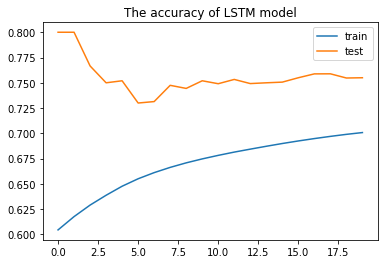

In [ ]:
import matplotlib.pyplot as plt
plt.plot(A)
plt.plot(B[:20])
plt.title("The accuracy of LSTM model")
plt.legend(["train", "test"])
plt.show()

# 小結：
從結果來看增加訓練epoches也許會有更好的表現，20次的epoches還沒有到達穩定的結果，並且有出現一些overfitting的感覺，可加入正則項來重新訓練,也許會更好